In [1]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt 
from matplotlib import cm
from functools import partial
from multiprocessing import Pool
from scipy import stats
import scipy.optimize
import gc #Garbage collector
import glob
from pybt.myjson.encoder import myJSONDecoder
import sys  
sys.path.insert(0, '/eos/user/e/eljohnso/SWAN_projects/acc-models-tls-eliott-fork/ps_extraction/east-fast-extraction')
plt.style.use('ggplot')
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from functions import *

In [2]:
import importlib
import sys
importlib.reload(sys.modules['functions']) # Can be deleted - useful if modifications made to function file and not wanting to reload the whole notebook
from functions import *
from madx_functions import *

In [3]:
# settings for MADX
gamma = 25.598474067 # Previously obtained by: header_read, twiss_read = read_twiss_file('tfs/fast_extraction.twiss')
beta = np.sqrt(1-gamma**(-2))
exn=1.5e-6
eyn=1.5e-6
ex = exn/(beta*gamma)
ey = eyn/(beta*gamma)
momentum = 2 # beam momentum (GeV/c)
Brho = momentum*3.3356

In [4]:
MU_type= "T"
fieldmap = read_and_interpolate_fieldmap(MU_type,momentum)
interp_fieldmap = atr.interpolate_fieldmap(fieldmap)

reading field map T type: 533A/MUT_533_xy_grid.table
flipping signs of B-fields


In [5]:
############################### Stray field calculation ###############################
# Calculate the trajectories
# input angle and position of the beam in the global reference system
particle = 'proton'       # particle name: 'proton' or 'carbon12'
PS_radius = 70.079
subtending_angle = (2*np.pi/100)
sagitta = PS_radius*(1-np.cos(subtending_angle/2))
chord = PS_radius*2*np.sin(subtending_angle/2)

track_end_z_m = chord/2+1 # approximate location in longitudinal direction of the magnet at where to stop the tracking

angle_injection_deg = 5.093
vertical_offset = 0.546837
ang_glob = (-(angle_injection_deg)*np.pi/180, 0.0) # From points_faisceaux_visualizer
pos_glob = (vertical_offset,  0.0, -np.tan(subtending_angle/2)*(PS_radius) )

# Create particles
setGen = atr.SetGenerator(particle)
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': momentum_to_energy(momentum)*1000, 'dt': 0} # Distribution of the reference particle in local coordinate system | kinetic energy of the beam in MeV
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3) # set of distributions for 13 particles in local coordinate system
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob) # set of distributions for 13 particles in global coordinate system to be used for tracking

# run reference particle to determine the tracking-end line for the entire set
plane_ref = trackend_plane(interp_fieldmap, particle, set13_global[0], track_end_z_m)
def track_is_inside(x ,p , t, a=plane_ref[0], b=plane_ref[1], c=plane_ref[2], d=plane_ref[3]):
    return x[2] < -(a * x[0] + b * x[1] + d  ) / c

# Deletes the file content if it wasn't empty
f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "w")
f.write(f"") 
f.close()

# run only particle 0
input_zip = [set13_global[0]+(track_is_inside,)]
with Pool(6) as p:
    partial_track_one_particle = partial(track_one_particle, interp_fieldmap, particle) # We provide a subset of variables\n",
    tracks_set = p.map(partial_track_one_particle, input_zip)
tracks1 = atr.Tracks(tracks_set, particle)

In [6]:
file = open('/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt', 'r')
Lines = file.readlines()

x,y,z,Bx,By,Bz = [],[],[],[],[],[]

for line in Lines:
    
    my_temp_list = []
    split = line.split(',')

    x.append(float(split[0]))
    y.append(float(split[1]))
    z.append(float(split[2]))
    Bx.append(float(split[3]))
    By.append(float(split[4]))
    Bz.append(float(split[5]))

field1 = pd.DataFrame()

field1['x'] = x
field1['y'] = y
field1['z'] = z
field1['Bx'] = Bx
field1['By'] = By
field1['Bz'] = Bz

In [7]:
field1

x             y         z            Bx        By            Bz
0      0.546825  0.000000e+00 -2.202186  0.000000e+00  0.000633  0.000000e+00
1      0.546801  0.000000e+00 -2.201916  0.000000e+00  0.000635  0.000000e+00
2      0.546777  0.000000e+00 -2.201645  0.000000e+00  0.000636  0.000000e+00
3      0.546753  0.000000e+00 -2.201375  0.000000e+00  0.000637  0.000000e+00
4      0.546729  0.000000e+00 -2.201105  0.000000e+00  0.000638  0.000000e+00
...         ...           ...       ...           ...       ...           ...
20023  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20024  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20025  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20026  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20027  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20

[20028 rows x 6 columns]

In [8]:
############################### Stray field calculation ###############################
# Calculate the trajectories
# input angle and position of the beam in the global reference system
particle = 'proton'       # particle name: 'proton' or 'carbon12'
PS_radius = 70.079
subtending_angle = (2*np.pi/100)
sagitta = PS_radius*(1-np.cos(subtending_angle/2))
chord = PS_radius*2*np.sin(subtending_angle/2)


track_end_z_m = chord/2+1 # approximate location in longitudinal direction of the magnet at where to stop the tracking

angle_injection_deg = 5.093
vertical_offset = 0.546837+0.01 # Adding a little offset
ang_glob = (-(angle_injection_deg)*np.pi/180, 0.0) # From points_faisceaux_visualizer
pos_glob = (vertical_offset,  0.0, -np.tan(subtending_angle/2)*(PS_radius) )

# Create particles
setGen = atr.SetGenerator(particle)
distr_part_ref = {'dX': 0, 'dXP': 0, 'dY': 0, 'dYP': 0, 'dS': 0, 'en_MeV': momentum_to_energy(momentum)*1000, 'dt': 0} # Distribution of the reference particle in local coordinate system | kinetic energy of the beam in MeV
set13_local = setGen.get_part13_local(distr_part_ref, dX=1e-3, dXP=1e-3, dY=1e-3, dYP=1e-3, dt=4e-12, dD=1e-3) # set of distributions for 13 particles in local coordinate system
set13_global = setGen.get_partset_global(set_local=set13_local, pos_glob0=pos_glob, ang_glob0=ang_glob) # set of distributions for 13 particles in global coordinate system to be used for tracking

# run reference particle to determine the tracking-end line for the entire set
plane_ref = trackend_plane(interp_fieldmap, particle, set13_global[0], track_end_z_m)
def track_is_inside(x ,p , t, a=plane_ref[0], b=plane_ref[1], c=plane_ref[2], d=plane_ref[3]):
    return x[2] < -(a * x[0] + b * x[1] + d  ) / c

# Deletes the file content if it wasn't empty
f = open("/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt", "w")
f.write(f"") 
f.close()

# run only particle 0
input_zip = [set13_global[0]+(track_is_inside,)]
with Pool(6) as p:
    partial_track_one_particle = partial(track_one_particle, interp_fieldmap, particle) # We provide a subset of variables\n",
    tracks_set = p.map(partial_track_one_particle, input_zip)
tracks2 = atr.Tracks(tracks_set, particle)

In [9]:
file = open('/eos/user/e/eljohnso/SWAN_projects/btp_stray_elements/B-field/field.txt', 'r')
Lines = file.readlines()

x,y,z,Bx,By,Bz = [],[],[],[],[],[]

for line in Lines:
    
    my_temp_list = []
    split = line.split(',')

    x.append(float(split[0]))
    y.append(float(split[1]))
    z.append(float(split[2]))
    Bx.append(float(split[3]))
    By.append(float(split[4]))
    Bz.append(float(split[5]))

field2 = pd.DataFrame()

field2['x'] = x
field2['y'] = y
field2['z'] = z
field2['Bx'] = Bx
field2['By'] = By
field2['Bz'] = Bz

In [10]:
############################### Plotting ###############################
fig, ax = plt.subplots(figsize=(10,8), tight_layout = True)
ax.plot(tracks1.tracks_set[0]["z"],tracks1.tracks_set[0]["x"], label = f"Particle tracking")
ax.plot(tracks2.tracks_set[0]["z"],tracks2.tracks_set[0]["x"], label = f"Particle tracking")
# Plot fieldmap
plot_fieldmap_faster(fig, ax, fieldmap, "By", 'y',"z","x",0.0)
ax.set_title(f"Main unit type-{MU_type}, Momentum {momentum} GeV/c")

Text(0.5, 1.0, 'Main unit type-T, Momentum 2 GeV/c')

In [11]:
field1

x             y         z            Bx        By            Bz
0      0.546825  0.000000e+00 -2.202186  0.000000e+00  0.000633  0.000000e+00
1      0.546801  0.000000e+00 -2.201916  0.000000e+00  0.000635  0.000000e+00
2      0.546777  0.000000e+00 -2.201645  0.000000e+00  0.000636  0.000000e+00
3      0.546753  0.000000e+00 -2.201375  0.000000e+00  0.000637  0.000000e+00
4      0.546729  0.000000e+00 -2.201105  0.000000e+00  0.000638  0.000000e+00
...         ...           ...       ...           ...       ...           ...
20023  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20024  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20025  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20026  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20
20027  0.040791  2.389079e-20  3.201162 -5.020785e-21 -0.000916  7.026953e-20

[20028 rows x 6 columns]

In [12]:
field2

x             y         z            Bx        By            Bz
0      0.556825  0.000000e+00 -2.202186  0.000000e+00  0.000590  0.000000e+00
1      0.556801  0.000000e+00 -2.201916  0.000000e+00  0.000591  0.000000e+00
2      0.556777  0.000000e+00 -2.201645  0.000000e+00  0.000592  0.000000e+00
3      0.556753  0.000000e+00 -2.201375  0.000000e+00  0.000593  0.000000e+00
4      0.556729  0.000000e+00 -2.201105  0.000000e+00  0.000594  0.000000e+00
...         ...           ...       ...           ...       ...           ...
20022  0.053044  2.208606e-20  3.201135  3.065478e-22 -0.000899 -5.395811e-21
20023  0.053044  2.208606e-20  3.201135  3.065478e-22 -0.000899 -5.395811e-21
20024  0.053044  2.208606e-20  3.201135  3.065478e-22 -0.000899 -5.395811e-21
20025  0.053044  2.208606e-20  3.201135  3.065478e-22 -0.000899 -5.395811e-21
20026  0.053044  2.208606e-20  3.201135  3.065478e-22 -0.000899 -5.395811e-21

[20027 rows x 6 columns]

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(field1.sort_values(by=['z']).z, field1.sort_values(by=['z']).By, label="field1")
ax.plot(field2.sort_values(by=['z']).z, field2.sort_values(by=['z']).By, label="field2")
ax.set(xlabel='z [m]', ylabel='By [T]',
       title='B-y tracking')
ax.grid()
ax.legend()
# plt.savefig("fig/By_tracking.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(field1.z, field1.x, label="field1")
ax.scatter(field2.z, field2.x, label="field1")

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(field1.sort_values(by=['z']).z, (field1.sort_values(by=['z']).By-field2.sort_values(by=['z']).By)/(field1.sort_values(by=['z']).x-field2.sort_values(by=['z']).x), label="quadrupole")

# Compare with measurements

In [16]:
magnetic_components = open('magnetic_components.txt', 'r')
positions = open('position_elements.txt', 'r')
Lines_magnetic = magnetic_components.readlines()
Lines_position = positions.readlines()

list_magnetic = []
list_position = []

for line in Lines_magnetic:
    
    my_temp_list = []
    split_0 = line.split('{')
    name = split_0[0].split(' :')
    split_1 = split_0[1].split(',')
    dipole = split_1[0]
    quadrupole = split_1[1]
    sextupole = split_1[2]
    octupole = split_1[3].replace("};\n","")
    
    my_temp_list.append(name[0])
    my_temp_list.append(float(dipole))
    my_temp_list.append(float(quadrupole))
    my_temp_list.append(float(sextupole))
    my_temp_list.append(float(octupole))

    list_magnetic.append(my_temp_list)

for line in Lines_position:
    
    my_temp_list = []
    split_0 = line.split(' = ')
    name = split_0[0].split(',')

    position = split_0[1].replace(";\n","")
    
    my_temp_list.append(name[0])
    my_temp_list.append(float(position))

    list_position.append(my_temp_list)
    
df_magnetic = pd.DataFrame(list_magnetic, columns =['Name', 'K0 (Dipole)', 'K1 (Quadrupole)','K2 (Sextupole)','K3 (Octupole)'])
df_position = pd.DataFrame(list_position, columns =['Name', 'Position'])
inner_merged = pd.merge(df_magnetic, df_position)

[Text(0.5, 0, 's [m]'),
 Text(0, 0.5, 'Dipole component K0*L'),
 Text(0.5, 1.0, 'BTP Stray element \n K0*L (Dipole)')]

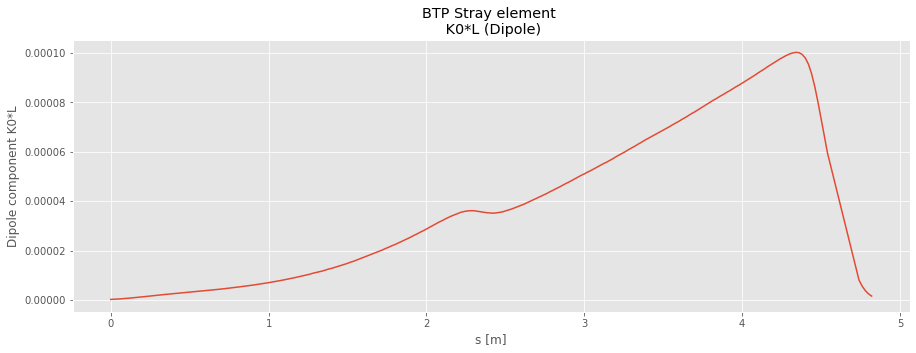

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inner_merged["Position"] - inner_merged["Position"][0], inner_merged["K0 (Dipole)"]) # We cancel the first x to start at zero

ax.set(xlabel='s [m]', ylabel='Dipole component K0*L',
       title='BTP Stray element \n K0*L (Dipole)')

# plt.savefig("fig/K0L_old_model.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(field1.sort_values(by=['z']).z, field1.sort_values(by=['z']).By, label="field1")
ax.plot(field2.sort_values(by=['z']).z, field2.sort_values(by=['z']).By, label="field2")
ax.set(xlabel='z [m]', ylabel='By [T]',
       title='B-y tracking')
ax.legend()

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inner_merged["Position"]-inner_merged["Position"][0], inner_merged["K1 (Quadrupole)"])

ax.set(xlabel='s [m]', ylabel='Dipole component K1*L',
       title='BTP Stray element \n K1*L (Quadrupole)')

# plt.savefig("fig/K0L_old_model.png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

[Text(0.5, 0, 's [m]'),
 Text(0, 0.5, 'Dipole component K1*L'),
 Text(0.5, 1.0, 'BTP Stray element \n K1*L (Quadrupole)')]

In [20]:
length_model = inner_merged["Position"].iloc[-1]-inner_merged["Position"][0]
length_model

4.819999999999997

In [21]:
len(inner_merged["Position"])

233

In [22]:
length_model/len(inner_merged)

0.020686695278969942

In [23]:
length_field=field1["z"].iloc[-1]-field1["z"][0]
length_field

5.4033479105671125

In [24]:
len(field1)

20028

In [25]:
length_field/(len(field1))

0.00026978968996240827

### Theory:

$ B_{y}(x,y) = B_{0} + B_{1}x + B_{2}\frac{1}{2}(x^{2}-y^{2}) + B_{3}\frac{1}{6}(x^{3}-3xy^{2}) $

#### In the old BTP model, we have $ K_{0}, K_{1}, K_{2}, K_{3} $

$ K_{0}L = \frac{B_{0}L}{B\rho} $

where $ L = \frac{totalLength}{\# elements} $

So to extract the pure $ K_{0} $ I divide by L


#### For tracking, we get the field components so I divide by $ B\rho $

$ B_{0} = K_{0}B\rho $

$  K_{0} = \frac{B_{0}}{B\rho} $

## stray1 and tracking start at a different location

In [26]:
distance_between_stray1_start_tracking = 0.1232841049668254
Image(filename = "fig/geode_btp_stray1_tracking.png", width=500, height=500)

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inner_merged["Position"]-inner_merged["Position"][0], inner_merged["K0 (Dipole)"]/(length_model/len(inner_merged)), label="Old model")

ax.plot(field1.sort_values(by=['z']).z-field1.sort_values(by=['z']).z[0]+distance_between_stray1_start_tracking, field1.sort_values(by=['z']).By/(2.794987*3.3356), label="Tracking")

ax.set(xlabel='s [m]', ylabel='Dipole component K0',
       title=f'BTP Stray multipole comparison \n K0 (Dipole) comparison, Main unit type-{MU_type}')

plt.legend()
plt.savefig("fig/BTP_stray_K0_comparison_MU"+str(MU_type)+".png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')

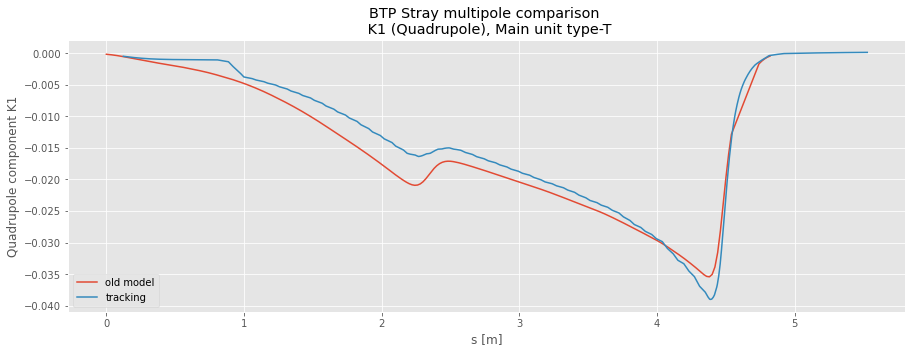

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(inner_merged["Position"]-inner_merged["Position"][0], inner_merged["K1 (Quadrupole)"]/(length_model/len(inner_merged)), label="old model")
ax.plot(field1.sort_values(by=['z']).z-field1.sort_values(by=['z']).z[0]+distance_between_stray1_start_tracking, ((field1.sort_values(by=['z']).By-field2.sort_values(by=['z']).By)/(field1.sort_values(by=['z']).x-field2.sort_values(by=['z']).x))/(2.794987*3.3356), label="tracking")

ax.set(xlabel='s [m]', ylabel='Quadrupole component K1',
       title=f'BTP Stray multipole comparison \n K1 (Quadrupole), Main unit type-{MU_type}')

ax.legend()
plt.savefig("fig/BTP_stray_K1_comparison_MU"+str(MU_type)+".png", facecolor='white', transparent=False, dpi = 150, bbox_inches='tight')